In [1]:
# 04_MODEL_EVALUATION.ipynb
# Cell 1: Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from pathlib import Path

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve
)

plt.style.use("seaborn-v0_8")
RANDOM_STATE = 42


In [2]:
# Cell 2: Load dataset & recreate target

# Adjust path if needed
possible_paths = [
    Path("loan_cleaned_for_model.csv"),
    Path("loan.csv"),
    Path("data/raw/loan.csv"),
    Path(r"C:\Credit-risk-scoring\data\raw\loan.csv")
]

DATA_PATH = None
for p in possible_paths:
    if p.exists():
        DATA_PATH = p
        break

if DATA_PATH is None:
    raise FileNotFoundError("Dataset not found. Update DATA_PATH in this cell.")

print("Loading:", DATA_PATH)
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)

# Identify bad loan statuses
bad_status = [
    "Charged Off",
    "Default",
    "Late (31-120 days)",
    "Late (16-30 days)",
    "Does not meet the credit policy. Status:Charged Off",
    "Does not meet the credit policy. Status:Default"
]

df["target"] = df["loan_status"].apply(lambda x: 1 if x in bad_status else 0)
df = df.drop(columns=["loan_status"])

print("\nTarget counts:")
print(df["target"].value_counts())


Loading: C:\Credit-risk-scoring\data\raw\loan.csv


C:\Users\devvr\AppData\Local\Temp\ipykernel_8044\1937665018.py:21: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


Shape: (2260668, 145)

Target counts:
target
0    1972587
1     288081
Name: count, dtype: int64


In [3]:
# Cell 3: Train-test split

from sklearn.model_selection import train_test_split

X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Train:", X_train.shape)
print("Test:", X_test.shape)


Train: (1808534, 144)
Test: (452134, 144)


In [5]:
# Cell 3b: Rebuild the same preprocessor used in training

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

# Recreate dropped columns logic
missing_pct = X_train.isna().mean() * 100
cols_to_drop = list(missing_pct[missing_pct > 95].index)
cols_to_drop += ["id", "member_id", "url", "desc", "title"]
cols_to_drop = list(dict.fromkeys(cols_to_drop))

X_train_clean = X_train.drop(columns=cols_to_drop, errors='ignore')
X_test_clean_raw = X_test.drop(columns=cols_to_drop, errors='ignore')

numeric_features = X_train_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X_train_clean.columns if c not in numeric_features]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    sparse_threshold=0.3
)

print("Preprocessor rebuilt successfully.")


Preprocessor rebuilt successfully.


In [6]:
# Cell 4 (updated): Fit preprocessor on training data, transform test data

preprocessor.fit(X_train_clean, y_train)
X_test_clean = preprocessor.transform(X_test_clean_raw)

print("X_test_clean shape:", X_test_clean.shape)


X_test_clean shape: (452134, 434899)


In [8]:
# Cell 5: Load saved models

models = {}

for name in ["logistic", "random_forest", "xgboost"]:
    file = f"pipeline_{name}.joblib"
    if Path(file).exists():
        models[name] = joblib.load(file)
        print(f"Loaded {file}")
    else:
        print(f"{file} not found, skipping.")

if not models:
    raise ValueError("No saved models found! Run training notebook first.")


Loaded pipeline_logistic.joblib
Loaded pipeline_random_forest.joblib
Loaded pipeline_xgboost.joblib


In [10]:
# Cell 6: Evaluation helper function

def evaluate_model(model, X_test, y_test, name="Model"):
    print(f"\n===== Evaluating {name} =====")

    # Predictions
    y_pred = model.predict(X_test)

    # Probabilities
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
    except:
        try:
            y_proba = model.decision_function(X_test)
        except:
            y_proba = None

    # Metrics
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    roc  = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    return y_pred, y_proba


In [12]:
# Correct evaluation loop — USE RAW CLEAN INPUT, NOT PREPROCESSED
results = {}

for name, model in models.items():
    print(f"\nRunning evaluation for: {name}")
    y_pred, y_proba = evaluate_model(model, X_test_clean_raw, y_test, name)
    results[name] = {"pred": y_pred, "proba": y_proba}



Running evaluation for: logistic

===== Evaluating logistic =====
Accuracy:  0.9883
Precision: 0.9298
Recall:    0.9824
F1-score:  0.9554
ROC-AUC:   0.9980

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    394518
           1       0.93      0.98      0.96     57616

    accuracy                           0.99    452134
   macro avg       0.96      0.99      0.97    452134
weighted avg       0.99      0.99      0.99    452134

Confusion Matrix:
[[390246   4272]
 [  1012  56604]]

Running evaluation for: random_forest

===== Evaluating random_forest =====
Accuracy:  0.8706
Precision: 0.4953
Recall:    0.8104
F1-score:  0.6149
ROC-AUC:   0.9261

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92    394518
           1       0.50      0.81      0.61     57616

    accuracy                           0.87    452134
   macro avg       0.73      0

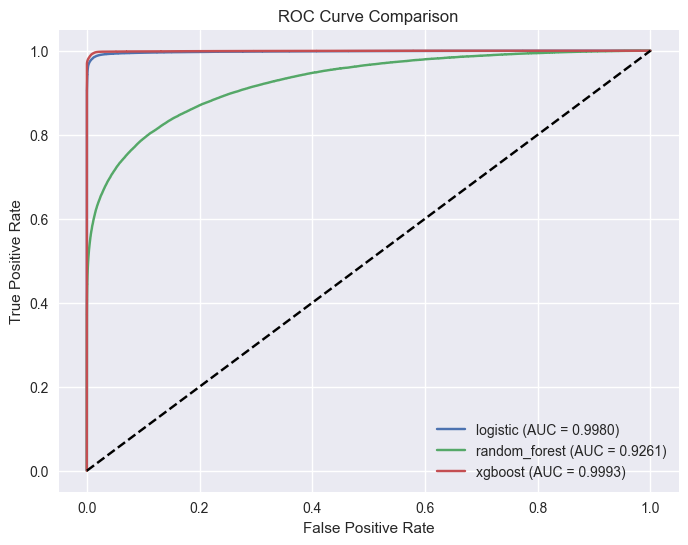

In [13]:
# Cell 8: ROC Curve

plt.figure(figsize=(8,6))

for name, res in results.items():
    y_proba = res["proba"]
    if y_proba is None:
        continue

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.4f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()


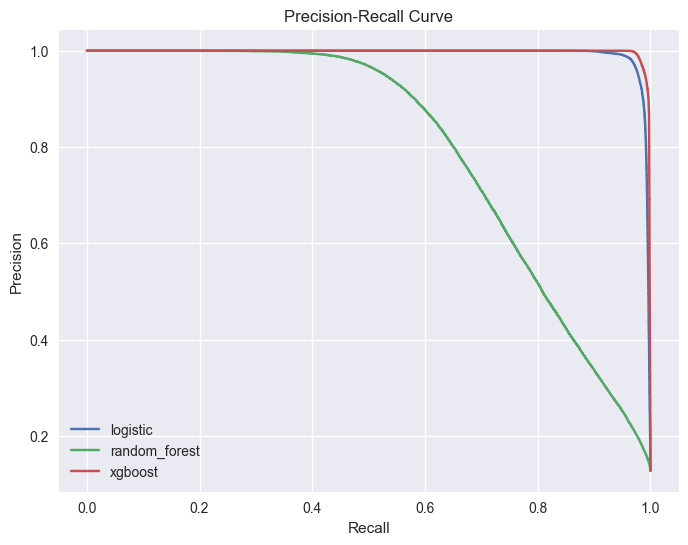

In [14]:
# Cell 9: Precision-Recall Curve

plt.figure(figsize=(8,6))

for name, res in results.items():
    y_proba = res["proba"]
    if y_proba is None:
        continue

    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(rec, prec, label=name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


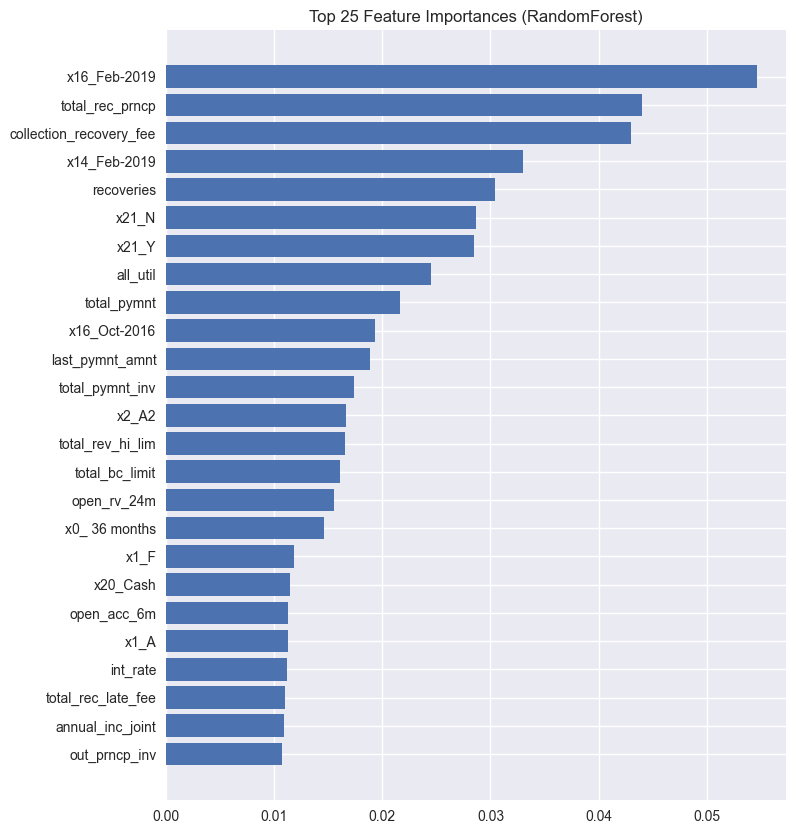

In [15]:
# Cell 10: Feature importance (RandomForest)

if "random_forest" in models:
    model = models["random_forest"]
    try:
        rf = model.named_steps["clf"]

        # Extract feature names
        ohe = model.named_steps["pre"].named_transformers_["cat"]["encoder"]
        cat_names = ohe.get_feature_names_out()
        num_names = model.named_steps["pre"].named_transformers_["num"].feature_names_in_

        feature_names = np.concatenate([num_names, cat_names])
        importances = rf.feature_importances_

        idx = np.argsort(importances)[::-1][:25]

        plt.figure(figsize=(8,10))
        plt.barh(feature_names[idx][::-1], importances[idx][::-1])
        plt.title("Top 25 Feature Importances (RandomForest)")
        plt.show()

    except Exception as e:
        print("Could not extract feature importance:", e)
else:
    print("RandomForest model not available.")
